In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
import os
import matplotlib

class TCRDataLoader:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.aa_dict = None
        self.v_dict = None
        self.j_dict = None
        self.label_map = None
        self.max_length = None
        
    def _create_vocabularies(self, df_tcr):
        """Create vocabularies for amino acids, V genes, and J genes"""
        # Amino acid vocabulary
        all_sequences = df_tcr['aminoAcid'].dropna()
        vocab = sorted(set(''.join(all_sequences)))
        self.aa_dict = {aa: i + 1 for i, aa in enumerate(vocab)}  # 0 reserved for padding
        
        # V gene vocabulary
        v_genes = df_tcr['v_beta'].dropna().unique()
        self.v_dict = {gene: i + 1 for i, gene in enumerate(sorted(v_genes))}  # 0 for unknown/NaN
        
        # J gene vocabulary  
        j_genes = df_tcr['j_beta'].dropna().unique()
        self.j_dict = {gene: i + 1 for i, gene in enumerate(sorted(j_genes))}  # 0 for unknown/NaN
        
        # Label mapping
        antigen_categories = df_tcr['Antigen'].cat.categories
        self.label_map = {i: antigen for i, antigen in enumerate(antigen_categories)}
        
    def _encode_sequences(self, sequences):
        """Encode amino acid sequences to integers"""
        encoded = np.zeros((len(sequences), self.max_length), dtype=np.int32)
        for i, seq in enumerate(sequences):
            for j, aa in enumerate(seq[:self.max_length]):
                encoded[i, j] = self.aa_dict.get(aa, 0)  # 0 for unknown amino acids
        return encoded
        
    def _encode_genes(self, genes, gene_dict):
        """Encode V/J genes to integers"""
        return np.array([gene_dict.get(gene, 0) for gene in genes], dtype=np.int32)
        
    def load_data(self, batch_size=100, shuffle=True):
        """
        Load TCR data from TSV files and return tensors
        
        Returns:
            tf.data.Dataset: Dataset with (inputs, labels) where inputs = (cdr3, v_gene, j_gene)
        """
        # Collect TSV files
        tsv_files = glob(os.path.join(self.data_dir, '*/*.tsv'))
        if not tsv_files:
            raise FileNotFoundError(f"No TSV files found in {self.data_dir}")
            
        df_rep = pd.DataFrame(tsv_files, columns=['filepath'])
        
        # Extract HLA and Antigen from file paths (handle Windows/Unix paths)
        df_rep[['HLA', 'Antigen']] = df_rep['filepath'].str.extract(r'[/\\]([^/\\-]+)-([^/\\-]+)[/\\][^/\\]+$')
        
        # Load all TSV files
        df_tcr_list = []
        for idx, row in df_rep.iterrows():
            df = pd.read_csv(row['filepath'], sep='\t')
            df['index'] = idx
            df[['HLA', 'Antigen']] = row[['HLA', 'Antigen']]
            df_tcr_list.append(df)
            
        df_tcr = pd.concat(df_tcr_list, ignore_index=True)
        df_tcr['Antigen'] = df_tcr['Antigen'].astype('category')
        
        # Filter valid sequences
        valid_idx = ~df_tcr[['aminoAcid', 'Antigen']].isna().any(axis=1)
        df_valid = df_tcr[valid_idx].copy()
        
        if len(df_valid) == 0:
            raise ValueError("No valid amino acid sequences found")
            
        # Create vocabularies
        self._create_vocabularies(df_valid)
        
        # Get max sequence length
        self.max_length = max(len(seq) for seq in df_valid['aminoAcid'])
        
        # Encode data
        X_sequences = self._encode_sequences(df_valid['aminoAcid'].values)
        X_v_genes = self._encode_genes(df_valid['v_beta'].fillna('UNK').values, self.v_dict)
        X_j_genes = self._encode_genes(df_valid['j_beta'].fillna('UNK').values, self.j_dict)
        y_labels = df_valid['Antigen'].cat.codes.values
        
        # Create TensorFlow dataset
        dataset = tf.data.Dataset.from_tensor_slices({
            'cdr3_sequence': X_sequences,
            'v_gene': X_v_genes,
            'j_gene': X_j_genes,
            'labels': y_labels
        })
        
        # Map to the format expected by the model: ((inputs), labels)
        dataset = dataset.map(lambda x: (
            (x['cdr3_sequence'], x['v_gene'], x['j_gene']),
            tf.one_hot(x['labels'], len(self.label_map))
        ))
        
        if shuffle:
            dataset = dataset.shuffle(len(df_valid))
            
        dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
        
        return dataset
    
    def get_vocab_sizes(self):
        """Return vocabulary sizes for model construction"""
        return {
            'aa_vocab_size': len(self.aa_dict) + 1,  # +1 for padding
            'v_vocab_size': len(self.v_dict) + 1,    # +1 for unknown
            'j_vocab_size': len(self.j_dict) + 1,    # +1 for unknown
            'num_classes': len(self.label_map),
            'max_length': self.max_length
        }
    
    def get_mappings(self):
        """Return the created mappings for inspection"""
        return {
            'aa_dict': self.aa_dict,
            'v_dict': self.v_dict,
            'j_dict': self.j_dict,
            'label_map': self.label_map
        }

In [2]:
def create_tcr_model(vocab_sizes):
    """Create a model that takes the fused CDR3 + VDJ input"""
    # Input layers
    cdr3_input = tf.keras.Input(shape=(vocab_sizes['max_length'],), name='cdr3_sequence')
    v_gene_input = tf.keras.Input(shape=(), name='v_gene')
    j_gene_input = tf.keras.Input(shape=(), name='j_gene')
    
    # Embeddings
    cdr3_embed = tf.keras.layers.Embedding(vocab_sizes['aa_vocab_size'], 64)(cdr3_input)
    v_embed = tf.keras.layers.Embedding(vocab_sizes['v_vocab_size'], 32)(v_gene_input)
    j_embed = tf.keras.layers.Embedding(vocab_sizes['j_vocab_size'], 32)(j_gene_input)
    
    # Process CDR3 sequence
    cdr3_lstm = tf.keras.layers.LSTM(128)(cdr3_embed)
    
    # Flatten gene embeddings
    v_flat = tf.keras.layers.Flatten()(v_embed)
    j_flat = tf.keras.layers.Flatten()(j_embed)
    
    # Fuse all features
    fused = tf.keras.layers.Concatenate()([cdr3_lstm, v_flat, j_flat])
    
    # Dense layers
    dense1 = tf.keras.layers.Dense(256, activation='relu')(fused)
    dense2 = tf.keras.layers.Dense(128, activation='relu')(dense1)
    output = tf.keras.layers.Dense(vocab_sizes['num_classes'], activation='softmax')(dense2)
    
    model = tf.keras.Model(
        inputs=[cdr3_input, v_gene_input, j_gene_input],
        outputs=output
    )
    
    return model

In [3]:
# Initialize loader
data_dir = '../DeepTCR/Data/Human_Antigens'
loader = TCRDataLoader(data_dir)

# Load data
print("Loading data...")
dataset = loader.load_data(batch_size=100, shuffle=True)
print("Data loaded successfully!")

Loading data...


C:\Users\huang\AppData\Local\Temp\ipykernel_36820\2290079753.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df[['HLA', 'Antigen']] = row[['HLA', 'Antigen']]
C:\Users\huang\AppData\Local\Temp\ipykernel_36820\2290079753.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df[['HLA', 'Antigen']] = row[['HLA', 'Antigen']]
C:\Users\huang\AppData\Local\Temp\ipykernel_36820\2290079753.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

Data loaded successfully!


In [4]:
# Get vocabulary sizes for model
vocab_sizes = loader.get_vocab_sizes()
print("Vocabulary sizes:")
for key, value in vocab_sizes.items():
    print(f"  {key}: {value}")

print("\nSample mappings:")
mappings = loader.get_mappings()
print(f"Sample amino acids: {list(mappings['aa_dict'].items())[:10]}")
print(f"V genes: {list(mappings['v_dict'].items())[:5]}")
print(f"J genes: {list(mappings['j_dict'].items())[:5]}")
print(f"Labels: {mappings['label_map']}")

Vocabulary sizes:
  aa_vocab_size: 21
  v_vocab_size: 36
  j_vocab_size: 14
  num_classes: 7
  max_length: 23

Sample mappings:
Sample amino acids: [('A', 1), ('C', 2), ('D', 3), ('E', 4), ('F', 5), ('G', 6), ('H', 7), ('I', 8), ('K', 9), ('L', 10)]
V genes: [('TCRBV-Apr', 1), ('TCRBV-Dec', 2), ('TCRBV-May', 3), ('TCRBV-Oct', 4), ('TCRBV03-01', 5)]
J genes: [('TCRBJ01-01', 1), ('TCRBJ01-02', 2), ('TCRBJ01-03', 3), ('TCRBJ01-04', 4), ('TCRBJ01-05', 5)]
Labels: {0: 'CTELKLSDY', 1: 'GILGFVFTL', 2: 'GLCTLVAML', 3: 'LPRRSGAAGA', 4: 'NLVPMVATV', 5: 'TPRVTGGGAM', 6: 'VTEHDTLLY'}


In [5]:
# Create model
print("Creating model...")
model = create_tcr_model(vocab_sizes)

# Compile model
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Display model summary
model.summary()

Creating model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cdr3_sequence       │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ v_gene (InputLayer) │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ j_gene (InputLayer) │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 23, 64)    │      1,344 │ cdr3_sequence[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 32)        │      1,152 │ v_gene[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 32)        │        448 │ j_gene[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     98,816 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     49,408 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7)         │        903 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 184,967 (722.53 KB)

 Trainable params: 184,967 (722.53 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Test one batch to verify shape
for batch in dataset.take(1):
    inputs, labels = batch
    cdr3, v_gene, j_gene = inputs
    
    print("Batch shapes:")
    print(f"  CDR3 sequences: {cdr3.shape}")
    print(f"  V genes: {v_gene.shape}")
    print(f"  J genes: {j_gene.shape}")
    print(f"  Labels: {labels.shape}")
    
    print(f"\nSample data:")
    print(f"  First CDR3: {cdr3[0][:10]}...")  # First 10 tokens
    print(f"  First V gene: {v_gene[0]}")
    print(f"  First J gene: {j_gene[0]}")
    print(f"  First label: {tf.argmax(labels[0])}")

Batch shapes:
  CDR3 sequences: (100, 23)
  V genes: (100,)
  J genes: (100,)
  Labels: (100, 7)

Sample data:
  First CDR3: [ 2  1 16 16 14  4  6 13 13  6]...
  First V gene: 7
  First J gene: 13
  First label: 2


Training model...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4294 - loss: 1.3781
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4322 - loss: 1.3640
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4492 - loss: 1.3089
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4443 - loss: 1.3298
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4791 - loss: 1.2768
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4770 - loss: 1.3057
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4877 - loss: 1.2890
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5186 - loss: 1.2280
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4801 - loss: 1.2611
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4959 - loss: 1.2506
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4993 - loss: 1.2184
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━

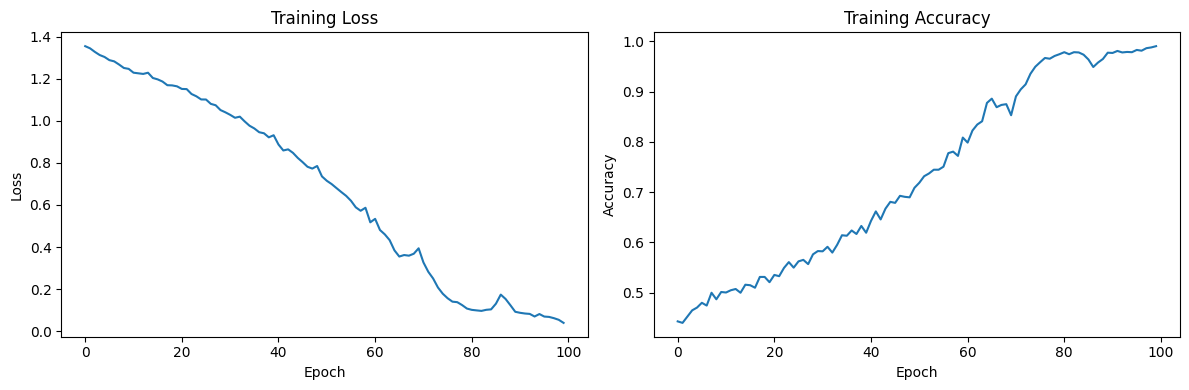

In [10]:
# Train the model
print("Training model...")
history = model.fit(
    dataset, 
    epochs=100,
    verbose=1
)

# Plot training history if you want
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()